In [1]:
%%capture

!pip install -r requirements.txt

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import unicodedata
import fasttext
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from wordcloud import WordCloud
import plotly.express as px

In [3]:
df = pd.read_csv('Balanced_AHR.csv')

In [4]:
df = df[df['rating'] >= 4]      # Solo reseñas positivas

In [5]:
# Eliminar columnas innecesarias
df = df.drop(['label', 'hotel', 'location', 'rating', 'Unnamed: 0'], axis=1)

In [6]:
# Crear una columna que combine title y review
df['text'] = df['title'].astype(str)+'. '+df['review_text'].astype(str)

In [7]:
# Crear lista con cada oración (separada por .) por separado
lista_text = df['text'].tolist()

sentences = []

for line in lista_text:
    line = line.rstrip()
    oraciones = line.split('.')
    for oracion in oraciones:
        oracion = oracion.lstrip(' ')
        sentences.append(oracion)
sentences = list(filter(None, sentences))

In [8]:
# Convertir la lista anterior a dataframe
df_sentences = pd.DataFrame (sentences, columns = ['text'])

In [9]:
# Limpieza del texto
def preprocesar_columna(df):
    df['text'] = df['text'].str.strip().str.lower()
    caracteres = ['!', ',', '&', ':', ';', '(', ')', '.', '?', '"']
    for car in caracteres:
        df['text'] = df['text'].str.replace(car,'', regex=False)
    df['text'] = df['text'].str.normalize('NFKC')
    df['text'] = df['text'].str.replace(r'([a-zA-Z])\1{2,}', r'\1', regex=True) 
    return df

In [10]:
df_sentences = preprocesar_columna(df_sentences)

In [11]:
def normalize_str(text_string):
    if text_string is not None:
        result = unicodedata.normalize('NFD', text_string).encode('ascii', 'ignore').decode()
    else:
        result = None
    return result

In [12]:
df_sentences['text'] = df_sentences['text'].apply(normalize_str)

In [13]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/gitpod/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [14]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/gitpod/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [15]:
stop_words = stopwords.words('spanish')

In [16]:
print(stop_words)

['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'del', 'se', 'las', 'por', 'un', 'para', 'con', 'no', 'una', 'su', 'al', 'lo', 'como', 'más', 'pero', 'sus', 'le', 'ya', 'o', 'este', 'sí', 'porque', 'esta', 'entre', 'cuando', 'muy', 'sin', 'sobre', 'también', 'me', 'hasta', 'hay', 'donde', 'quien', 'desde', 'todo', 'nos', 'durante', 'todos', 'uno', 'les', 'ni', 'contra', 'otros', 'ese', 'eso', 'ante', 'ellos', 'e', 'esto', 'mí', 'antes', 'algunos', 'qué', 'unos', 'yo', 'otro', 'otras', 'otra', 'él', 'tanto', 'esa', 'estos', 'mucho', 'quienes', 'nada', 'muchos', 'cual', 'poco', 'ella', 'estar', 'estas', 'algunas', 'algo', 'nosotros', 'mi', 'mis', 'tú', 'te', 'ti', 'tu', 'tus', 'ellas', 'nosotras', 'vosotros', 'vosotras', 'os', 'mío', 'mía', 'míos', 'mías', 'tuyo', 'tuya', 'tuyos', 'tuyas', 'suyo', 'suya', 'suyos', 'suyas', 'nuestro', 'nuestra', 'nuestros', 'nuestras', 'vuestro', 'vuestra', 'vuestros', 'vuestras', 'esos', 'esas', 'estoy', 'estás', 'está', 'estamos', 'estáis', 'están', 'e

In [17]:
for word in ['no', 'sin', 'nada']:
    stop_words.remove(word)

In [18]:
stop_words.append('hotel')

In [19]:
for i in range(len(stop_words)):
    stop_words[i] = normalize_str(stop_words[i])

In [20]:
def eliminar_stopwords(text_string):
    word_tokens = word_tokenize(text_string)
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    sentence = ' '.join(str(x) for x in filtered_sentence)
    return sentence

In [21]:
df_sentences['text_sin_stopwords'] = df_sentences['text'].apply(eliminar_stopwords)

In [22]:
tfile = open('positivo.txt', 'a')
tfile.write(df_sentences['text_sin_stopwords'].to_string())
tfile.close()

In [23]:
model = fasttext.train_unsupervised('positivo.txt')

Read 0M words
Number of words:  1649
Number of labels: 0
Progress: 100.0% words/sec/thread:   36624 lr:  0.000000 avg.loss:  2.823813 ETA:   0h 0m 0s


In [24]:
df_sentences['vec'] = df_sentences['text_sin_stopwords'].apply(lambda x: model.get_sentence_vector(x))

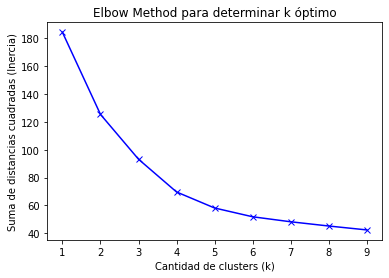

In [25]:
sum_distancias_cuadradas = []

K = range(1,10)
for num_clusters in K :
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(df_sentences['vec'].values.tolist())
    sum_distancias_cuadradas.append(kmeans.inertia_)

plt.plot(K, sum_distancias_cuadradas, 'bx-')
plt.xlabel('Cantidad de clusters (k)')
plt.ylabel('Suma de distancias cuadradas (Inercia)')
plt.title('Elbow Method para determinar k óptimo')
plt.show()

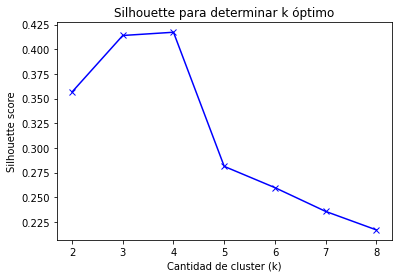

In [26]:
# Método para determinar la cantidad óptima de clusters

rango_n_clusters = [2, 3, 4, 5, 6, 7, 8]
silhouette_avg = []

for num_clusters in rango_n_clusters:

    # fit Kmeans
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(df_sentences['vec'].values.tolist())
    cluster_labels = kmeans.labels_

    # calcular silhouette
    silhouette_avg.append(silhouette_score(df_sentences['vec'].values.tolist(), cluster_labels))

plt.plot(rango_n_clusters, silhouette_avg, 'bx-')    
plt.xlabel('Cantidad de cluster (k)')
plt.ylabel('Silhouette score')
plt.title('Silhouette para determinar k óptimo')
plt.show()

In [27]:
kmeans = KMeans(n_clusters=4)

In [28]:
df_sentences['cluster'] = kmeans.fit_predict(df_sentences['vec'].values.tolist())

In [30]:
cluster_0 = df_sentences[df_sentences['cluster']==0]
cluster_1 = df_sentences[df_sentences['cluster']==1]
cluster_2 = df_sentences[df_sentences['cluster']==2]
cluster_3 = df_sentences[df_sentences['cluster']==3]

In [31]:
def generate_wordcloud(df):
    text = ' '.join([i for i in df['text_sin_stopwords']])
    wordcloud = WordCloud(max_words=100, background_color='Black').generate(text)
    plt.figure(figsize=(12,12))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.show()

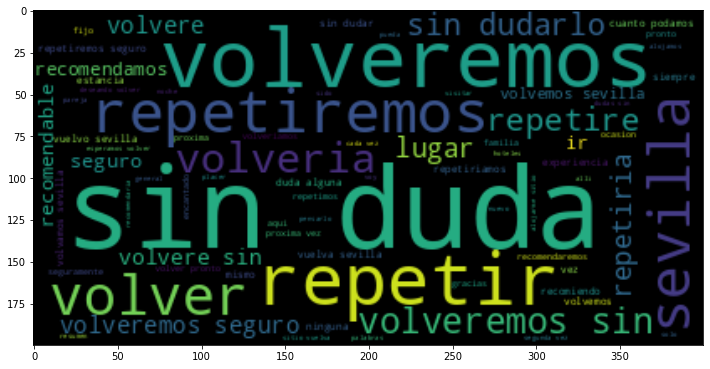

In [32]:
generate_wordcloud(cluster_0)

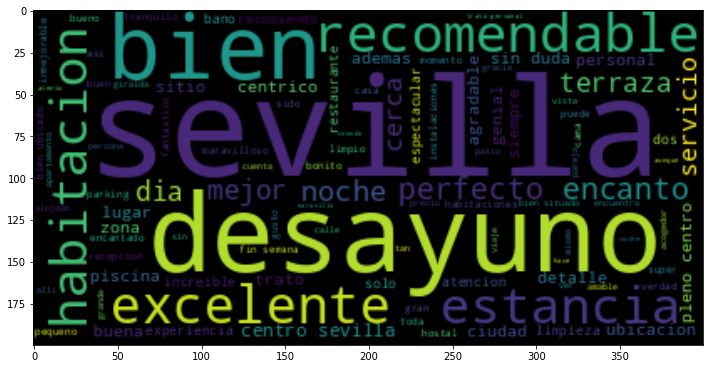

In [33]:
generate_wordcloud(cluster_1)

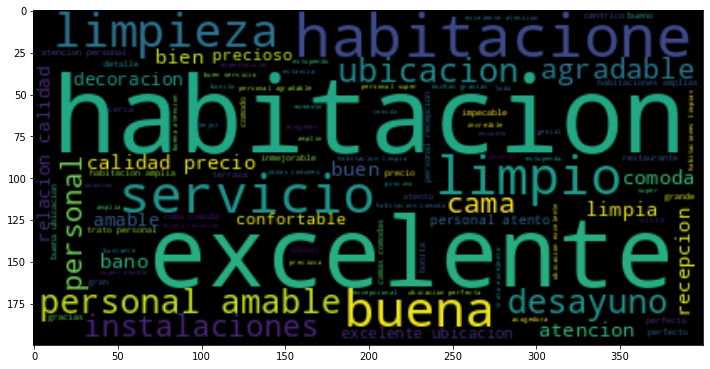

In [34]:
generate_wordcloud(cluster_2)

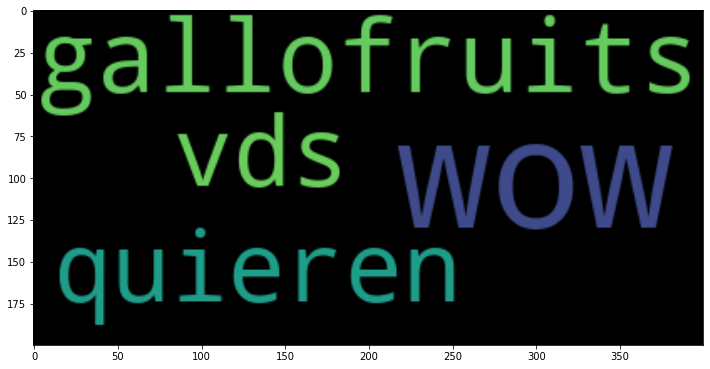

In [35]:
generate_wordcloud(cluster_3)

In [37]:
# Componentes principales para hacer plot en 3D

pca = PCA(n_components=3)
df_sentences['x'] = pca.fit_transform(df_sentences['vec'].values.tolist())[:,0]
df_sentences['y'] = pca.fit_transform(df_sentences['vec'].values.tolist())[:,1]
df_sentences['z'] = pca.fit_transform(df_sentences['vec'].values.tolist())[:,2]

In [38]:
df_sentences['cluster'] = df_sentences['cluster'].astype('category')

In [39]:
fig = px.scatter_3d(df_sentences, x='x', y='y', z='z', color='cluster')
fig.update_traces(marker_size = 2)
fig.show()

In [ ]:
# Hacer resumen

https://towardsdatascience.com/making-sense-of-text-clustering-ca649c190b20#:~:text=For%20a%20refresh%2C%20clustering%20is,learn%20the%20pattern%20by%20itself.